# Tuning Neural Networks with Regularization - Lab

## Introduction

Recall from the last lab that you had a training accuracy close to 90% and a test set accuracy close to 76%.

As with your previous machine learning work, you should be asking a couple of questions:
- Is there high bias? yes/no
- Is there high variance? yes/no 

In this lab, you'll use the a train-validate-test partition as well as a validation set to get better insights of how to tune neural networks using regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. From there, you'll define and compile the model like before. However, this time, when you are presented with the `history` dictionary of the model, you will have additional data entries for not only the train and test set but also the validation set.

## Objectives

You will be able to:

* Construct and run a basic model in Keras
* Construct a validation set and explain potential benefits
* Apply L1 and L2 regularization
* Apply dropout regularization
* Observe and comment on the effect of using more data

## Import the libraries

As usual, start by importing some of the packages and modules that you intend to use. The first thing you'll be doing is importing the data and taking a random sample, so that should clue you in to what tools to import. If you need more tools down the line, you can always import additional packages later.

In [1]:
# Import the libraries

import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


## Load the Data

As with the previous lab, the data is stored in a file **Bank_complaints.csv**. Load and preview the dataset.

In [2]:
# load and preview the dataset
df = pd.read_csv('./Bank_complaints.csv')
df.tail()

,Product,Consumer complaint narrative
59995,Credit reporting,"In XXXX, I defaulted on a credit card with XXX..."
59996,Credit reporting,I HAVE CALLED TRANSUNION JUST ABOUT EVERY MONT...
59997,Credit reporting,"Hello, there is a 2012 Chapter XXXX Bankruptcy..."
59998,Credit reporting,I had a 2 yr internet contract with XXXX XXXX ...
59999,Credit reporting,I filed a complaint against XXXX XXXX XXXX wit...


In [3]:
df.shape

(60000, 2)

In [4]:
df['Product'].unique()

array(['Student loan', 'Credit card', 'Bank account or service',
       'Consumer Loan', 'Checking or savings account', 'Mortgage',
       'Credit reporting'], dtype=object)

## Preprocessing Overview

Before you begin to practice some of your new tools regarding regularization and optimization, let's practice munging some data as you did in the previous section with bank complaints. Recall some techniques:

* Train - test split
* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* One-hot encoding your complaint text
* Transforming your category labels

## Preprocessing: Generate a Random Sample

Since you have quite a bit of data and training networks takes a substantial amount of time and resources, downsample in order to test your initial pipeline. Going forward, these can be interesting areas of investigation: how does your models performance change as you increase (or decrease) the size of your dataset?  

Generate the random sample using seed 123 for consistency of results. Make your new sample have 10,000 observations.

In [5]:
# Generate Random Sample from original dataset
df_sample = df.sample(10000, random_state=123)
y = df_sample['Product']
X = df_sample['Consumer complaint narrative']
print(y.head(), X.head())

29561              Consumer Loan
26640    Bank account or service
24498    Bank account or service
24594    Bank account or service
24249    Bank account or service
Name: Product, dtype: object 29561    I want to file a " Bait and Switch '' Complain...
26640    I am an account holder for my personal, busine...
24498    they took my whole social security check i had...
24594    This is in dispute of my Case number : XXXX. I...
24249    My Bluebird card that i used for bill pay was ...
Name: Consumer complaint narrative, dtype: object


## Train-test Split

Below, perform an appropriate train test split.

In [6]:
# Perform an appropriate train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1500, random_state = 42)

## Running the model using a validation set.

## Creating the Validation Set

In the lecture, you saw that in deep learning, you generally set aside a validation set, which is then used during hyperparameter tuning. Afterwards, when you have decided upon a final model, the test can then be used to define the final model perforance. 

In this example, take the first 1000 cases out of the training set to create a validation set. You should do this for both `train` and `label_train`.

In [7]:
# Creating the Validation Set

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=1000, random_state=123)

## Preprocessing: One-hot Encoding of the Complaints

As before, you need to do some preprocessing and data manipulationg before building the neural network. 

Keep the 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors.

In [9]:
# Using one-hot encoding reformat the complaints into a matrix of vectors.
# Only keep the 2000 most common words.

# num_words: the maximum number of words to keep, based on word frequency. Only the most common `num_words` words will be kept.
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final)

# Convert a list of texts to a Numpy matrix.
X_train_tok = tokenizer.texts_to_matrix(X_train_final, mode='binary')
X_train_tok


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [10]:
X_val = tokenizer.texts_to_matrix(X_val, mode='binary')
X_val

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
> **Note**: This is similar to your previous work with dummy variables. Each of the various product categories will be its own column, and each observation will be a row. In turn, each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero.

In [13]:
#Transform the product labels to numerical values
#Then transform these integer values into a matrix of binary flags


lb = LabelBinarizer()
lb.fit(y_train_final)

y_train_lb = to_categorical(lb.transform(y_train_final))[:, :, 1]
y_val = to_categorical(lb.transform(y_val))[:, :, 1]

## Creating the Model

Rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that you used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because you are dealing with a multiclass problem (classifying the complaints into 7 classes), use a softmax classifyer in order to output 7 class probabilities per case. 

In [14]:
from keras import models
from keras import layers

In [18]:
#Your code here; build a neural network using Keras as described above.
random.seed(123)

nn_clf = models.Sequential()
nn_clf.add(layers.Dense(units = 50, activation='relu', kernel_initializer='glorot_uniform', input_shape=(2000,))) # Input Layer
nn_clf.add(layers.Dense(units = 25, activation='relu'))   # 1st Hidden Layer
nn_clf.add(layers.Dense(units = 7, activation='softmax'))   # Output Layer


## Compiling the Model
In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, include the argument `validation_data` and assign it `(val, label_val)`

In [19]:
#Your code here
nn_clf.compile(optimizer='SGD',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

## Training the Model

Ok, now for the resource intensive part: time to train your model! Note that this is where you also introduce the validation data to the model.

In [21]:
#Code provided; note the extra validation parameter passed.
model_val = nn_clf.fit(X_train_tok,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 94us/step - loss: 1.9139 - acc: 0.1825 - val_loss: 1.9197 - val_acc: 0.1900
Epoch 2/120
7500/7500 [==============================] - 0s 61us/step - loss: 1.8969 - acc: 0.2109 - val_loss: 1.9047 - val_acc: 0.2000
Epoch 3/120
7500/7500 [==============================] - 0s 63us/step - loss: 1.8784 - acc: 0.2245 - val_loss: 1.8875 - val_acc: 0.2150
Epoch 4/120
7500/7500 [==============================] - 0s 62us/step - loss: 1.8573 - acc: 0.2456 - val_loss: 1.8672 - val_acc: 0.2300
Epoch 5/120
7500/7500 [==============================] - 0s 61us/step - loss: 1.8328 - acc: 0.2575 - val_loss: 1.8437 - val_acc: 0.2390
Epoch 6/120
7500/7500 [==============================] - 0s 59us/step - loss: 1.8053 - acc: 0.2661 - val_loss: 1.8179 - val_acc: 0.2450
Epoch 7/120
7500/7500 [==============================] - 0s 59us/step - loss: 1.7753 - acc: 0.2795 - val_loss: 1.7892 - val_acc: 0.2610


7500/7500 [==============================] - 0s 60us/step - loss: 0.5857 - acc: 0.8005 - val_loss: 0.7666 - val_acc: 0.7290
Epoch 61/120
7500/7500 [==============================] - 0s 59us/step - loss: 0.5797 - acc: 0.8013 - val_loss: 0.7647 - val_acc: 0.7270
Epoch 62/120
7500/7500 [==============================] - 0s 57us/step - loss: 0.5738 - acc: 0.8009 - val_loss: 0.7613 - val_acc: 0.7280
Epoch 63/120
7500/7500 [==============================] - 0s 58us/step - loss: 0.5698 - acc: 0.8044 - val_loss: 0.7597 - val_acc: 0.7300
Epoch 64/120
7500/7500 [==============================] - 0s 57us/step - loss: 0.5642 - acc: 0.8059 - val_loss: 0.7582 - val_acc: 0.7290
Epoch 65/120
7500/7500 [==============================] - 0s 54us/step - loss: 0.5594 - acc: 0.8069 - val_loss: 0.7542 - val_acc: 0.7250
Epoch 66/120
7500/7500 [==============================] - 0s 57us/step - loss: 0.5543 - acc: 0.8093 - val_loss: 0.7551 - val_acc: 0.7200
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 55us/step - loss: 0.3668 - acc: 0.8808 - val_loss: 0.7317 - val_acc: 0.7450


## Retrieving Performance Results: the `history` dictionary

The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [22]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [24]:
results_train = nn_clf.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

7500/7500 [==============================] - 1s 75us/step
Training Loss: 0.363 Training Accuracy: 0.883


## Preprocess then evaluate our models performance on the test set

In [26]:
X_test_tok = tokenizer.texts_to_matrix(X_test, mode='binary')
y_test_cat = to_categorical(lb.transform(y_test))[:, :, 1]

results_test = nn_clf.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

1500/1500 [==============================] - 0s 66us/step
Testing Loss: 0.623 Testing Accuracy: 0.781


In [28]:
nn_clf.metrics_names

['loss', 'acc']

The first element of the list returned by `model.evaluate` is the loss, and the second is the accuracy score. 

Note that the result you obtained here isn't exactly the same as before. This is because the training set is slightly different! You removed 1000 instances for validation!

## Plotting the Results

Plot the loss function versus the number of epochs. Be sure to include the training and the validation loss in the same plot. Then, create a second plot comparing training and validation accuracy to the number of epochs.

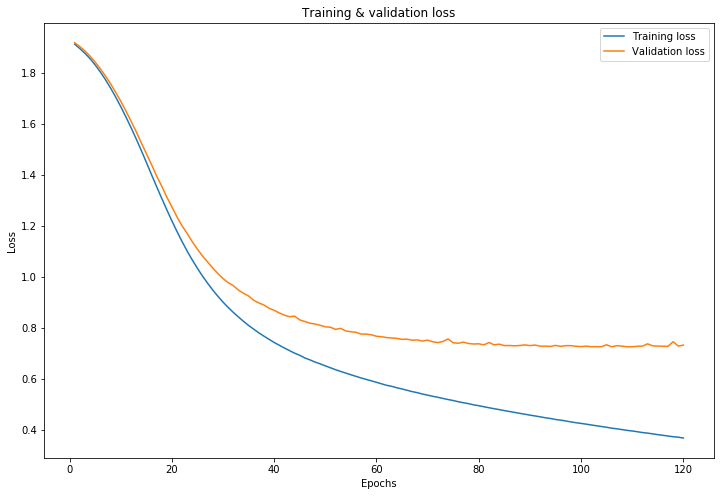

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();


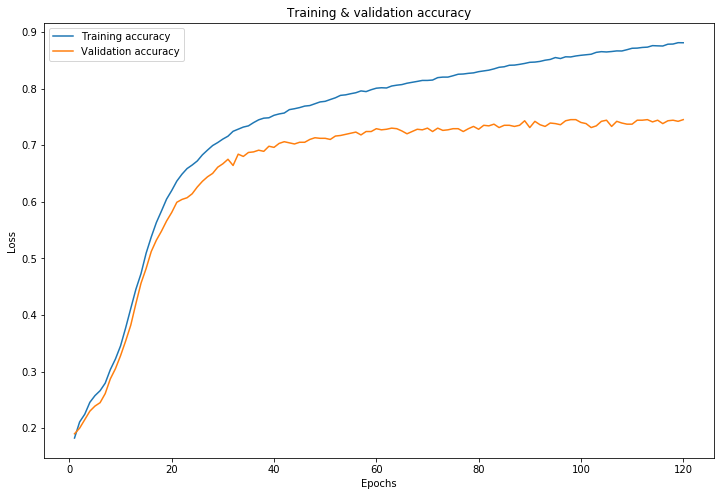

In [33]:
# Accuracy vs number of epochs with train and val set
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = model_val_dict['acc'] 
val_acc_values = model_val_dict['val_acc']

ax.plot(epochs, acc_values, label='Training accuracy')
ax.plot(epochs, val_acc_values, label='Validation accuracy')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

Notice an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a limit around the 60th epoch. This means that you're probably **overfitting** the model to the training data when you train for many epochs past this dropoff point of around 40 epochs. Luckily, you learned how to tackle overfitting in the previous lecture! Since it seems clear that you are training too long, include early stopping at the 60th epoch first.

## Early Stopping

Below, observe how to update the model to include an earlier cutoff point:

In [36]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=60,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/60
7500/7500 [==============================] - 1s 78us/step - loss: 1.9544 - acc: 0.1445 - val_loss: 1.9427 - val_acc: 0.1330
Epoch 2/60
7500/7500 [==============================] - 0s 57us/step - loss: 1.9291 - acc: 0.1745 - val_loss: 1.9237 - val_acc: 0.1740
Epoch 3/60
7500/7500 [==============================] - 0s 58us/step - loss: 1.9069 - acc: 0.2101 - val_loss: 1.9033 - val_acc: 0.1890
Epoch 4/60
7500/7500 [==============================] - 0s 58us/step - loss: 1.8822 - acc: 0.2420 - val_loss: 1.8796 - val_acc: 0.2380
Epoch 5/60
7500/7500 [==============================] - 0s 56us/step - loss: 1.8528 - acc: 0.2752 - val_loss: 1.8510 - val_acc: 0.2740
Epoch 6/60
7500/7500 [==============================] - 0s 57us/step - loss: 1.8186 - acc: 0.3125 - val_loss: 1.8178 - val_acc: 0.3050
Epoch 7/60
7500/7500 [==============================] - 0s 59us/step - loss: 1.7798 - acc: 0.3460 - val_loss: 1.7801 - val_acc: 0.3380
Epoch 8

Now, you can use the test set to make label predictions

In [37]:
results_train = model.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

7500/7500 [==============================] - 0s 64us/step
Training Loss: 0.544 Training Accuracy: 0.814
1500/1500 [==============================] - 0s 73us/step
Testing Loss: 0.656 Testing Accuracy: 0.747


We've significantly reduced the variance, so this is already pretty good! your test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs model you originally fit.

Now, take a look at how regularization techniques can further improve your model performance.

## L2 Regularization

First, take a look at L2 regularization. Keras makes L2 regularization easy. Simply add the `kernel_regularizer=keras.regularizers.l2(lambda_coeff)` parameter to any model layer. The `lambda_coeff` parameter determines the strength of the regularization you wish to perform.

In [38]:
from keras import regularizers
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 89us/step - loss: 2.5961 - acc: 0.1455 - val_loss: 2.5826 - val_acc: 0.1700
Epoch 2/120
7500/7500 [==============================] - 0s 63us/step - loss: 2.5711 - acc: 0.1816 - val_loss: 2.5617 - val_acc: 0.1950
Epoch 3/120
7500/7500 [==============================] - 0s 65us/step - loss: 2.5503 - acc: 0.2065 - val_loss: 2.5421 - val_acc: 0.2280
Epoch 4/120
7500/7500 [==============================] - 1s 70us/step - loss: 2.5289 - acc: 0.2271 - val_loss: 2.5210 - val_acc: 0.2380
Epoch 5/120
7500/7500 [==============================] - 1s 68us/step - loss: 2.5053 - acc: 0.2461 - val_loss: 2.4979 - val_acc: 0.2450
Epoch 6/120
7500/7500 [==============================] - 0s 59us/step - loss: 2.4784 - acc: 0.2619 - val_loss: 2.4714 - val_acc: 0.2640
Epoch 7/120
7500/7500 [==============================] - 0s 57us/step - loss: 2.4466 - acc: 0.2901 - val_loss: 2.4398 - val_acc: 0.3010


7500/7500 [==============================] - 0s 63us/step - loss: 1.1231 - acc: 0.8083 - val_loss: 1.2724 - val_acc: 0.7450
Epoch 61/120
7500/7500 [==============================] - 0s 60us/step - loss: 1.1161 - acc: 0.8108 - val_loss: 1.2682 - val_acc: 0.7470
Epoch 62/120
7500/7500 [==============================] - 1s 69us/step - loss: 1.1098 - acc: 0.8119 - val_loss: 1.2646 - val_acc: 0.7410
Epoch 63/120
7500/7500 [==============================] - 0s 60us/step - loss: 1.1033 - acc: 0.8135 - val_loss: 1.2598 - val_acc: 0.7450
Epoch 64/120
7500/7500 [==============================] - 1s 70us/step - loss: 1.0966 - acc: 0.8143 - val_loss: 1.2560 - val_acc: 0.7450
Epoch 65/120
7500/7500 [==============================] - 0s 58us/step - loss: 1.0905 - acc: 0.8173 - val_loss: 1.2533 - val_acc: 0.7480
Epoch 66/120
7500/7500 [==============================] - 0s 59us/step - loss: 1.0842 - acc: 0.8179 - val_loss: 1.2496 - val_acc: 0.7480
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 64us/step - loss: 0.8403 - acc: 0.8803 - val_loss: 1.1306 - val_acc: 0.7670


In [39]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Now, look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

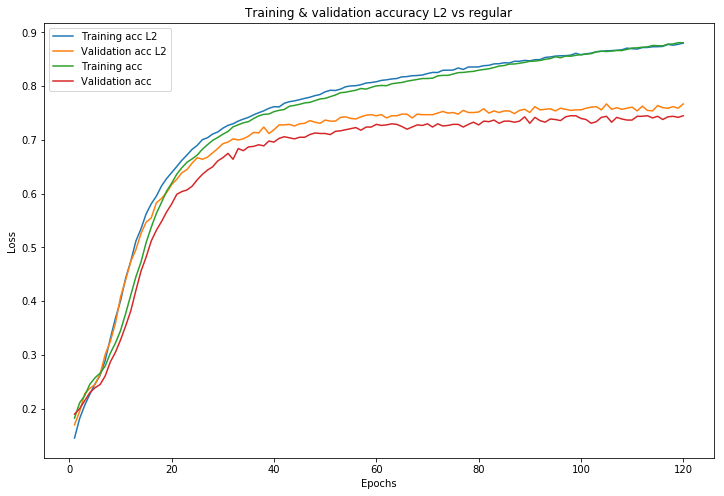

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = L2_model_dict['acc'] 
val_acc_values = L2_model_dict['val_acc']
model_acc = model_val_dict['acc']
model_val_acc = model_val_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L2')
ax.plot(epochs, val_acc_values, label='Validation acc L2')
ax.plot(epochs, model_acc, label='Training acc')
ax.plot(epochs, model_val_acc, label='Validation acc')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

The results of L2 regularization are quite disappointing here. Notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## L1 Regularization

Have a look at L1 regularization. Will this work better?

In [44]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 104us/step - loss: 16.0224 - acc: 0.1881 - val_loss: 15.6296 - val_acc: 0.1730
Epoch 2/120
7500/7500 [==============================] - 0s 60us/step - loss: 15.2645 - acc: 0.1975 - val_loss: 14.8871 - val_acc: 0.1840
Epoch 3/120
7500/7500 [==============================] - 0s 62us/step - loss: 14.5308 - acc: 0.2064 - val_loss: 14.1667 - val_acc: 0.1850
Epoch 4/120
7500/7500 [==============================] - 0s 60us/step - loss: 13.8171 - acc: 0.2125 - val_loss: 13.4658 - val_acc: 0.1950
Epoch 5/120
7500/7500 [==============================] - 0s 60us/step - loss: 13.1218 - acc: 0.2201 - val_loss: 12.7836 - val_acc: 0.2040
Epoch 6/120
7500/7500 [==============================] - 0s 60us/step - loss: 12.4459 - acc: 0.2336 - val_loss: 12.1207 - val_acc: 0.2200
Epoch 7/120
7500/7500 [==============================] - 0s 62us/step - loss: 11.7895 - acc: 0.2504 - val_loss: 11.4776 - v

7500/7500 [==============================] - 0s 60us/step - loss: 1.7667 - acc: 0.6875 - val_loss: 1.8175 - val_acc: 0.6650
Epoch 61/120
7500/7500 [==============================] - 0s 60us/step - loss: 1.7554 - acc: 0.6889 - val_loss: 1.8057 - val_acc: 0.6670
Epoch 62/120
7500/7500 [==============================] - 0s 59us/step - loss: 1.7446 - acc: 0.6881 - val_loss: 1.7962 - val_acc: 0.6630
Epoch 63/120
7500/7500 [==============================] - 0s 60us/step - loss: 1.7343 - acc: 0.6877 - val_loss: 1.7850 - val_acc: 0.6690
Epoch 64/120
7500/7500 [==============================] - 1s 77us/step - loss: 1.7235 - acc: 0.6913 - val_loss: 1.7748 - val_acc: 0.6670
Epoch 65/120
7500/7500 [==============================] - 0s 62us/step - loss: 1.7139 - acc: 0.6901 - val_loss: 1.7644 - val_acc: 0.6670
Epoch 66/120
7500/7500 [==============================] - 0s 59us/step - loss: 1.7043 - acc: 0.6900 - val_loss: 1.7546 - val_acc: 0.6680
Epoch 67/120
7500/7500 [==============================

7500/7500 [==============================] - 1s 70us/step - loss: 1.3450 - acc: 0.7200 - val_loss: 1.4072 - val_acc: 0.6940
Epoch 120/120
7500/7500 [==============================] - 1s 67us/step - loss: 1.3400 - acc: 0.7204 - val_loss: 1.4084 - val_acc: 0.6970


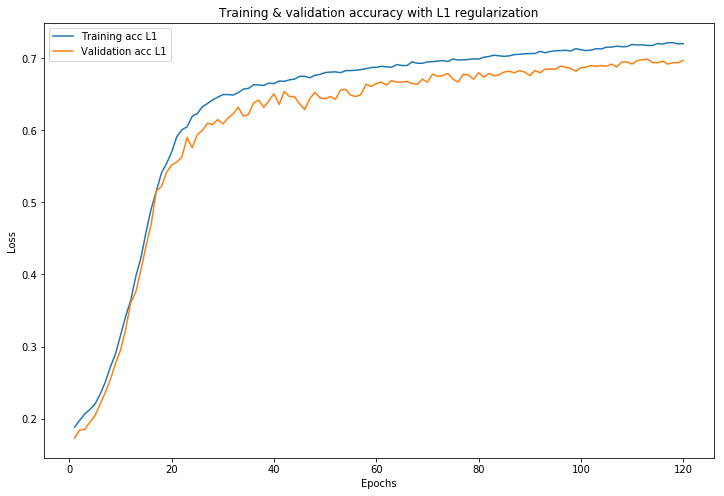

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

Notice how the training and validation accuracy don't diverge as much as before. Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like you can still improve the model by training much longer.

In [47]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=1000,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/1000
7500/7500 [==============================] - 1s 106us/step - loss: 16.0063 - acc: 0.1596 - val_loss: 15.6079 - val_acc: 0.1820
Epoch 2/1000
7500/7500 [==============================] - 0s 61us/step - loss: 15.2538 - acc: 0.1988 - val_loss: 14.8687 - val_acc: 0.2180
Epoch 3/1000
7500/7500 [==============================] - 0s 59us/step - loss: 14.5239 - acc: 0.2307 - val_loss: 14.1514 - val_acc: 0.2390
Epoch 4/1000
7500/7500 [==============================] - 0s 62us/step - loss: 13.8152 - acc: 0.2541 - val_loss: 13.4543 - val_acc: 0.2500
Epoch 5/1000
7500/7500 [==============================] - 0s 59us/step - loss: 13.1260 - acc: 0.2745 - val_loss: 12.7765 - val_acc: 0.2640
Epoch 6/1000
7500/7500 [==============================] - 0s 58us/step - loss: 12.4557 - acc: 0.2973 - val_loss: 12.1176 - val_acc: 0.2930
Epoch 7/1000
7500/7500 [==============================] - 0s 62us/step - loss: 11.8043 - acc: 0.3224 - val_loss: 11.4

Epoch 60/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.7371 - acc: 0.6948 - val_loss: 1.7676 - val_acc: 0.6820
Epoch 61/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.7273 - acc: 0.6963 - val_loss: 1.7599 - val_acc: 0.6860
Epoch 62/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.7181 - acc: 0.6976 - val_loss: 1.7524 - val_acc: 0.6830
Epoch 63/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.7091 - acc: 0.6979 - val_loss: 1.7427 - val_acc: 0.6870
Epoch 64/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.7001 - acc: 0.6971 - val_loss: 1.7350 - val_acc: 0.6860
Epoch 65/1000
7500/7500 [==============================] - 0s 60us/step - loss: 1.6917 - acc: 0.6983 - val_loss: 1.7235 - val_acc: 0.6830
Epoch 66/1000
7500/7500 [==============================] - 0s 59us/step - loss: 1.6824 - acc: 0.6992 - val_loss: 1.7170 - val_acc: 0.6870
Epoch 67/1000
7500/7500 [=========

Epoch 119/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.3494 - acc: 0.7193 - val_loss: 1.3846 - val_acc: 0.6990
Epoch 120/1000
7500/7500 [==============================] - 0s 67us/step - loss: 1.3443 - acc: 0.7179 - val_loss: 1.3829 - val_acc: 0.7060
Epoch 121/1000
7500/7500 [==============================] - 0s 62us/step - loss: 1.3396 - acc: 0.7197 - val_loss: 1.3792 - val_acc: 0.7040
Epoch 122/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.3353 - acc: 0.7207 - val_loss: 1.3748 - val_acc: 0.7020
Epoch 123/1000
7500/7500 [==============================] - 0s 61us/step - loss: 1.3306 - acc: 0.7217 - val_loss: 1.3703 - val_acc: 0.7080
Epoch 124/1000
7500/7500 [==============================] - 1s 83us/step - loss: 1.3264 - acc: 0.7213 - val_loss: 1.3698 - val_acc: 0.7120
Epoch 125/1000
7500/7500 [==============================] - 1s 71us/step - loss: 1.3220 - acc: 0.7223 - val_loss: 1.3607 - val_acc: 0.7080
Epoch 126/1000
7500/7500 [=

7500/7500 [==============================] - 0s 59us/step - loss: 1.1520 - acc: 0.7369 - val_loss: 1.2000 - val_acc: 0.7220
Epoch 178/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.1503 - acc: 0.7380 - val_loss: 1.1953 - val_acc: 0.7170
Epoch 179/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.1482 - acc: 0.7373 - val_loss: 1.1973 - val_acc: 0.7200
Epoch 180/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.1466 - acc: 0.7371 - val_loss: 1.1926 - val_acc: 0.7250
Epoch 181/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.1438 - acc: 0.7376 - val_loss: 1.1898 - val_acc: 0.7210
Epoch 182/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.1418 - acc: 0.7360 - val_loss: 1.1881 - val_acc: 0.7230
Epoch 183/1000
7500/7500 [==============================] - 0s 55us/step - loss: 1.1397 - acc: 0.7353 - val_loss: 1.1899 - val_acc: 0.7220
Epoch 184/1000
7500/7500 [================

7500/7500 [==============================] - 0s 62us/step - loss: 1.0604 - acc: 0.7449 - val_loss: 1.1202 - val_acc: 0.7310
Epoch 237/1000
7500/7500 [==============================] - 0s 64us/step - loss: 1.0597 - acc: 0.7443 - val_loss: 1.1170 - val_acc: 0.7320
Epoch 238/1000
7500/7500 [==============================] - 0s 60us/step - loss: 1.0582 - acc: 0.7456 - val_loss: 1.1197 - val_acc: 0.7230
Epoch 239/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.0576 - acc: 0.7467 - val_loss: 1.1158 - val_acc: 0.7300
Epoch 240/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.0565 - acc: 0.7468 - val_loss: 1.1157 - val_acc: 0.7300
Epoch 241/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.0551 - acc: 0.7465 - val_loss: 1.1147 - val_acc: 0.7360
Epoch 242/1000
7500/7500 [==============================] - 0s 60us/step - loss: 1.0539 - acc: 0.7477 - val_loss: 1.1110 - val_acc: 0.7320
Epoch 243/1000
7500/7500 [================

7500/7500 [==============================] - 0s 57us/step - loss: 1.0025 - acc: 0.7572 - val_loss: 1.0720 - val_acc: 0.7470
Epoch 296/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.0019 - acc: 0.7600 - val_loss: 1.0726 - val_acc: 0.7460
Epoch 297/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.0019 - acc: 0.7584 - val_loss: 1.0770 - val_acc: 0.7470
Epoch 298/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.0013 - acc: 0.7575 - val_loss: 1.0711 - val_acc: 0.7450
Epoch 299/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.0005 - acc: 0.7567 - val_loss: 1.0728 - val_acc: 0.7400
Epoch 300/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.9989 - acc: 0.7564 - val_loss: 1.0670 - val_acc: 0.7460
Epoch 301/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.9976 - acc: 0.7592 - val_loss: 1.0710 - val_acc: 0.7400
Epoch 302/1000
7500/7500 [================

Epoch 354/1000
7500/7500 [==============================] - 0s 64us/step - loss: 0.9629 - acc: 0.7675 - val_loss: 1.0482 - val_acc: 0.7520
Epoch 355/1000
7500/7500 [==============================] - 1s 78us/step - loss: 0.9625 - acc: 0.7676 - val_loss: 1.0495 - val_acc: 0.7430
Epoch 356/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.9623 - acc: 0.7675 - val_loss: 1.0434 - val_acc: 0.7480
Epoch 357/1000
7500/7500 [==============================] - 0s 65us/step - loss: 0.9615 - acc: 0.7671 - val_loss: 1.0407 - val_acc: 0.7570
Epoch 358/1000
7500/7500 [==============================] - 0s 63us/step - loss: 0.9613 - acc: 0.7677 - val_loss: 1.0402 - val_acc: 0.7520
Epoch 359/1000
7500/7500 [==============================] - 1s 68us/step - loss: 0.9597 - acc: 0.7680 - val_loss: 1.0394 - val_acc: 0.7480
Epoch 360/1000
7500/7500 [==============================] - 0s 63us/step - loss: 0.9587 - acc: 0.7676 - val_loss: 1.0466 - val_acc: 0.7470
Epoch 361/1000
7500/7500 [=

7500/7500 [==============================] - 0s 60us/step - loss: 0.9347 - acc: 0.7737 - val_loss: 1.0299 - val_acc: 0.7450
Epoch 413/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.9335 - acc: 0.7735 - val_loss: 1.0267 - val_acc: 0.7550
Epoch 414/1000
7500/7500 [==============================] - 0s 65us/step - loss: 0.9346 - acc: 0.7743 - val_loss: 1.0257 - val_acc: 0.7460
Epoch 415/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.9329 - acc: 0.7728 - val_loss: 1.0246 - val_acc: 0.7470
Epoch 416/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.9313 - acc: 0.7743 - val_loss: 1.0238 - val_acc: 0.7510
Epoch 417/1000
7500/7500 [==============================] - 1s 67us/step - loss: 0.9334 - acc: 0.7740 - val_loss: 1.0238 - val_acc: 0.7520
Epoch 418/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.9319 - acc: 0.7749 - val_loss: 1.0280 - val_acc: 0.7550
Epoch 419/1000
7500/7500 [================

Epoch 471/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.9124 - acc: 0.7785 - val_loss: 1.0193 - val_acc: 0.7450
Epoch 472/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.9124 - acc: 0.7784 - val_loss: 1.0116 - val_acc: 0.7510
Epoch 473/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.9130 - acc: 0.7787 - val_loss: 1.0107 - val_acc: 0.7590
Epoch 474/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.9118 - acc: 0.7783 - val_loss: 1.0112 - val_acc: 0.7550
Epoch 475/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.9117 - acc: 0.7781 - val_loss: 1.0135 - val_acc: 0.7490
Epoch 476/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.9129 - acc: 0.7776 - val_loss: 1.0086 - val_acc: 0.7520
Epoch 477/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.9109 - acc: 0.7788 - val_loss: 1.0272 - val_acc: 0.7360
Epoch 478/1000
7500/7500 [=

Epoch 530/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8971 - acc: 0.7824 - val_loss: 1.0046 - val_acc: 0.7480
Epoch 531/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8979 - acc: 0.7809 - val_loss: 1.0130 - val_acc: 0.7420
Epoch 532/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8961 - acc: 0.7833 - val_loss: 1.0056 - val_acc: 0.7440
Epoch 533/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8963 - acc: 0.7815 - val_loss: 1.0078 - val_acc: 0.7490
Epoch 534/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8964 - acc: 0.7816 - val_loss: 1.0069 - val_acc: 0.7500
Epoch 535/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8965 - acc: 0.7819 - val_loss: 1.0132 - val_acc: 0.7460
Epoch 536/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.8959 - acc: 0.7816 - val_loss: 1.0005 - val_acc: 0.7510
Epoch 537/1000
7500/7500 [=

Epoch 589/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8841 - acc: 0.7864 - val_loss: 1.0027 - val_acc: 0.7460
Epoch 590/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.8845 - acc: 0.7859 - val_loss: 1.0162 - val_acc: 0.7370
Epoch 591/1000
7500/7500 [==============================] - 1s 67us/step - loss: 0.8841 - acc: 0.7852 - val_loss: 1.0175 - val_acc: 0.7380
Epoch 592/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8835 - acc: 0.7865 - val_loss: 1.0121 - val_acc: 0.7520
Epoch 593/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8846 - acc: 0.7869 - val_loss: 1.0071 - val_acc: 0.7510
Epoch 594/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.8829 - acc: 0.7869 - val_loss: 0.9960 - val_acc: 0.7470
Epoch 595/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8818 - acc: 0.7875 - val_loss: 0.9986 - val_acc: 0.7540
Epoch 596/1000
7500/7500 [=

Epoch 648/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8718 - acc: 0.7909 - val_loss: 1.0012 - val_acc: 0.7480
Epoch 649/1000
7500/7500 [==============================] - 1s 73us/step - loss: 0.8729 - acc: 0.7905 - val_loss: 0.9904 - val_acc: 0.7570
Epoch 650/1000
7500/7500 [==============================] - 0s 64us/step - loss: 0.8714 - acc: 0.7903 - val_loss: 0.9940 - val_acc: 0.7530
Epoch 651/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8719 - acc: 0.7903 - val_loss: 1.0191 - val_acc: 0.7390
Epoch 652/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8716 - acc: 0.7916 - val_loss: 0.9921 - val_acc: 0.7610
Epoch 653/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8716 - acc: 0.7919 - val_loss: 1.0017 - val_acc: 0.7570
Epoch 654/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8727 - acc: 0.7879 - val_loss: 1.0123 - val_acc: 0.7460
Epoch 655/1000
7500/7500 [=

Epoch 707/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.8627 - acc: 0.7937 - val_loss: 0.9978 - val_acc: 0.7450
Epoch 708/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8595 - acc: 0.7943 - val_loss: 1.0006 - val_acc: 0.7480
Epoch 709/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.8596 - acc: 0.7933 - val_loss: 0.9862 - val_acc: 0.7570
Epoch 710/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8589 - acc: 0.7976 - val_loss: 0.9983 - val_acc: 0.7460
Epoch 711/1000
7500/7500 [==============================] - 1s 78us/step - loss: 0.8643 - acc: 0.7912 - val_loss: 0.9799 - val_acc: 0.7650
Epoch 712/1000
7500/7500 [==============================] - 0s 64us/step - loss: 0.8610 - acc: 0.7955 - val_loss: 0.9928 - val_acc: 0.7510
Epoch 713/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8609 - acc: 0.7893 - val_loss: 1.0027 - val_acc: 0.7520
Epoch 714/1000
7500/7500 [=

7500/7500 [==============================] - 0s 54us/step - loss: 0.8521 - acc: 0.7984 - val_loss: 0.9842 - val_acc: 0.7580
Epoch 766/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8504 - acc: 0.8003 - val_loss: 0.9777 - val_acc: 0.7600
Epoch 767/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8482 - acc: 0.7997 - val_loss: 0.9821 - val_acc: 0.7560
Epoch 768/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8496 - acc: 0.7992 - val_loss: 0.9936 - val_acc: 0.7490
Epoch 769/1000
7500/7500 [==============================] - 0s 60us/step - loss: 0.8489 - acc: 0.7989 - val_loss: 1.0208 - val_acc: 0.7490
Epoch 770/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8526 - acc: 0.7959 - val_loss: 0.9834 - val_acc: 0.7610
Epoch 771/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8480 - acc: 0.8009 - val_loss: 0.9830 - val_acc: 0.7600
Epoch 772/1000
7500/7500 [================

7500/7500 [==============================] - 0s 49us/step - loss: 0.8420 - acc: 0.8044 - val_loss: 0.9822 - val_acc: 0.7580
Epoch 825/1000
7500/7500 [==============================] - 0s 53us/step - loss: 0.8403 - acc: 0.8019 - val_loss: 0.9819 - val_acc: 0.7620
Epoch 826/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8429 - acc: 0.7999 - val_loss: 0.9856 - val_acc: 0.7590
Epoch 827/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8395 - acc: 0.8067 - val_loss: 0.9792 - val_acc: 0.7550
Epoch 828/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8407 - acc: 0.8015 - val_loss: 0.9824 - val_acc: 0.7510
Epoch 829/1000
7500/7500 [==============================] - 0s 50us/step - loss: 0.8414 - acc: 0.8047 - val_loss: 1.0180 - val_acc: 0.7400
Epoch 830/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8450 - acc: 0.8028 - val_loss: 0.9889 - val_acc: 0.7560
Epoch 831/1000
7500/7500 [================

7500/7500 [==============================] - 0s 51us/step - loss: 0.8317 - acc: 0.8064 - val_loss: 0.9853 - val_acc: 0.7600
Epoch 884/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8366 - acc: 0.8044 - val_loss: 0.9764 - val_acc: 0.7580
Epoch 885/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8303 - acc: 0.8101 - val_loss: 1.0021 - val_acc: 0.7490
Epoch 886/1000
7500/7500 [==============================] - 0s 51us/step - loss: 0.8302 - acc: 0.8096 - val_loss: 1.0303 - val_acc: 0.7310
Epoch 887/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8381 - acc: 0.8029 - val_loss: 0.9934 - val_acc: 0.7590
Epoch 888/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8328 - acc: 0.8049 - val_loss: 0.9773 - val_acc: 0.7640
Epoch 889/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8283 - acc: 0.8099 - val_loss: 0.9841 - val_acc: 0.7540
Epoch 890/1000
7500/7500 [================

7500/7500 [==============================] - 1s 91us/step - loss: 0.8355 - acc: 0.8051 - val_loss: 1.0643 - val_acc: 0.7180
Epoch 943/1000
7500/7500 [==============================] - 0s 63us/step - loss: 0.8257 - acc: 0.8084 - val_loss: 1.1300 - val_acc: 0.6780
Epoch 944/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8389 - acc: 0.8036 - val_loss: 0.9947 - val_acc: 0.7480
Epoch 945/1000
7500/7500 [==============================] - 1s 72us/step - loss: 0.8228 - acc: 0.8117 - val_loss: 0.9835 - val_acc: 0.7530
Epoch 946/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8266 - acc: 0.8068 - val_loss: 0.9800 - val_acc: 0.7580
Epoch 947/1000
7500/7500 [==============================] - 0s 52us/step - loss: 0.8232 - acc: 0.8148 - val_loss: 0.9697 - val_acc: 0.7640
Epoch 948/1000
7500/7500 [==============================] - 0s 49us/step - loss: 0.8307 - acc: 0.8048 - val_loss: 0.9835 - val_acc: 0.7590
Epoch 949/1000
7500/7500 [================

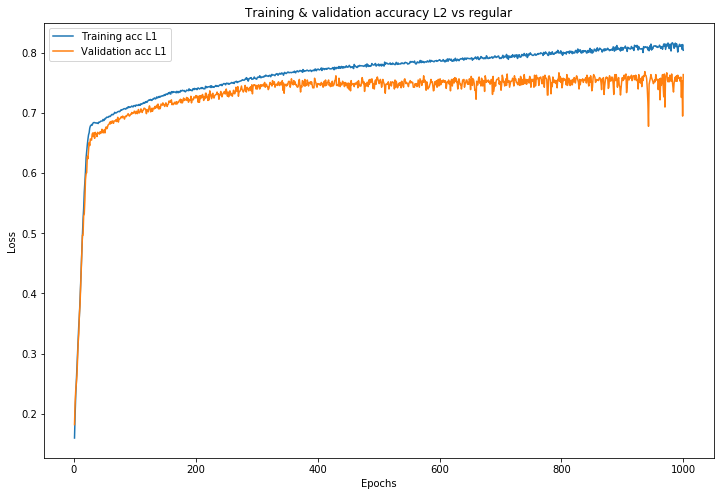

In [50]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model.history

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [51]:
results_train = model.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

7500/7500 [==============================] - 1s 95us/step
Training Loss: 0.81 Training Accuracy: 0.817
1500/1500 [==============================] - 0s 191us/step
Testing Loss: 0.879 Testing Accuracy: 0.789


This is about the best result you've achieved so far, but you were training for quite a while! Next, experiment with dropout regularization to see if it offers any advantages.

## Dropout Regularization

In [52]:
# ⏰ This cell may take about a minute to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(X_train_tok,
                    y_train_lb,
                    epochs=200,
                    batch_size=256,
                    validation_data=(X_val, y_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/200
7500/7500 [==============================] - 1s 164us/step - loss: 1.9865 - acc: 0.1557 - val_loss: 1.9331 - val_acc: 0.1850
Epoch 2/200
7500/7500 [==============================] - 1s 102us/step - loss: 1.9554 - acc: 0.1717 - val_loss: 1.9190 - val_acc: 0.2370
Epoch 3/200
7500/7500 [==============================] - 1s 98us/step - loss: 1.9422 - acc: 0.1812 - val_loss: 1.9091 - val_acc: 0.2430
Epoch 4/200
7500/7500 [==============================] - 1s 120us/step - loss: 1.9270 - acc: 0.2004 - val_loss: 1.9009 - val_acc: 0.2390
Epoch 5/200
7500/7500 [==============================] - 1s 140us/step - loss: 1.9143 - acc: 0.2115 - val_loss: 1.8927 - val_acc: 0.2450
Epoch 6/200
7500/7500 [==============================] - 1s 128us/step - loss: 1.9077 - acc: 0.2197 - val_loss: 1.8844 - val_acc: 0.2490
Epoch 7/200
7500/7500 [==============================] - 1s 117us/step - loss: 1.8991 - acc: 0.2269 - val_loss: 1.8757 - val_acc: 0

7500/7500 [==============================] - 1s 85us/step - loss: 1.2013 - acc: 0.5563 - val_loss: 0.9904 - val_acc: 0.6990
Epoch 61/200
7500/7500 [==============================] - 1s 85us/step - loss: 1.1771 - acc: 0.5623 - val_loss: 0.9811 - val_acc: 0.6990
Epoch 62/200
7500/7500 [==============================] - 1s 85us/step - loss: 1.1674 - acc: 0.5647 - val_loss: 0.9692 - val_acc: 0.7020
Epoch 63/200
7500/7500 [==============================] - 1s 85us/step - loss: 1.1802 - acc: 0.5503 - val_loss: 0.9642 - val_acc: 0.7020
Epoch 64/200
7500/7500 [==============================] - 1s 84us/step - loss: 1.1595 - acc: 0.5676 - val_loss: 0.9552 - val_acc: 0.7060
Epoch 65/200
7500/7500 [==============================] - 1s 93us/step - loss: 1.1589 - acc: 0.5684 - val_loss: 0.9510 - val_acc: 0.7050
Epoch 66/200
7500/7500 [==============================] - 1s 112us/step - loss: 1.1419 - acc: 0.5725 - val_loss: 0.9415 - val_acc: 0.7020
Epoch 67/200
7500/7500 [=============================

7500/7500 [==============================] - 1s 94us/step - loss: 0.9070 - acc: 0.6700 - val_loss: 0.7397 - val_acc: 0.7500
Epoch 120/200
7500/7500 [==============================] - 1s 92us/step - loss: 0.9049 - acc: 0.6680 - val_loss: 0.7377 - val_acc: 0.7510
Epoch 121/200
7500/7500 [==============================] - 1s 93us/step - loss: 0.9061 - acc: 0.6673 - val_loss: 0.7351 - val_acc: 0.7490
Epoch 122/200
7500/7500 [==============================] - 1s 93us/step - loss: 0.8925 - acc: 0.6739 - val_loss: 0.7328 - val_acc: 0.7490
Epoch 123/200
7500/7500 [==============================] - 1s 96us/step - loss: 0.8924 - acc: 0.6657 - val_loss: 0.7338 - val_acc: 0.7500
Epoch 124/200
7500/7500 [==============================] - 1s 101us/step - loss: 0.8909 - acc: 0.6740 - val_loss: 0.7313 - val_acc: 0.7520
Epoch 125/200
7500/7500 [==============================] - 1s 97us/step - loss: 0.8880 - acc: 0.6701 - val_loss: 0.7308 - val_acc: 0.7480
Epoch 126/200
7500/7500 [======================

7500/7500 [==============================] - 1s 93us/step - loss: 0.7792 - acc: 0.7129 - val_loss: 0.6768 - val_acc: 0.7610
Epoch 179/200
7500/7500 [==============================] - 1s 99us/step - loss: 0.7790 - acc: 0.7132 - val_loss: 0.6752 - val_acc: 0.7620
Epoch 180/200
7500/7500 [==============================] - 1s 99us/step - loss: 0.7653 - acc: 0.7107 - val_loss: 0.6749 - val_acc: 0.7620
Epoch 181/200
7500/7500 [==============================] - 1s 90us/step - loss: 0.7769 - acc: 0.7141 - val_loss: 0.6734 - val_acc: 0.7610
Epoch 182/200
7500/7500 [==============================] - 1s 92us/step - loss: 0.7643 - acc: 0.7160 - val_loss: 0.6728 - val_acc: 0.7590
Epoch 183/200
7500/7500 [==============================] - 1s 90us/step - loss: 0.7770 - acc: 0.7140 - val_loss: 0.6742 - val_acc: 0.7610
Epoch 184/200
7500/7500 [==============================] - 1s 94us/step - loss: 0.7699 - acc: 0.7115 - val_loss: 0.6708 - val_acc: 0.7630
Epoch 185/200
7500/7500 [=======================

In [53]:
results_train = model.evaluate(X_train_tok, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_tok, y_test_cat)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')   

7500/7500 [==============================] - 1s 77us/step
Training Loss: 0.453 Training Accuracy: 0.843
1500/1500 [==============================] - 0s 71us/step
Testing Loss: 0.577 Testing Accuracy: 0.789


You can see here that the validation performance has improved again! The variance did become higher again compared to L1-regularization.

## Bigger Data?

In the lecture, one of the solutions to high variance was just getting more data. You actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple your data set, and see what happens. Note that you are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [54]:
df = pd.read_csv('Bank_complaints.csv')
df = df.sample(40000, random_state=123)

X = df["Consumer complaint narrative"]
y = df["Product"]

# train test split
X_train_lrg, X_test_lrg, y_train_lrg, y_test_lrg = train_test_split(X, y, random_state=42)

#Validation set
X_train_final_lrg, X_val_lrg, y_train_final_lrg, y_val_lrg = train_test_split(X_train_lrg, y_train_lrg, random_state=123)


#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_train_final_lrg)

X_train_tok_lrg = tokenizer.texts_to_matrix(X_train_final_lrg, mode='binary')
X_val_lrg = tokenizer.texts_to_matrix(X_val_lrg, mode='binary')
X_test_lrg = tokenizer.texts_to_matrix(X_test_lrg, mode='binary')

#one-hot encoding of products
lb = LabelBinarizer()
lb.fit(y_train_final_lrg)

y_train_lb_lrg = to_categorical(lb.transform(y_train_final_lrg))[:, :, 1]
y_val_lrg = to_categorical(lb.transform(y_val_lrg))[:, :, 1]
y_test_lrg = to_categorical(lb.transform(y_test_lrg))[:, :, 1]

In [55]:
# ⏰ This cell may take several minutes to run
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(X_train_tok_lrg,
                    y_train_lb_lrg,
                    epochs=120,
                    batch_size=256,
                    validation_data=(X_val_lrg, y_val_lrg))

Train on 22500 samples, validate on 7500 samples
Epoch 1/120
22500/22500 [==============================] - 2s 89us/step - loss: 1.9312 - acc: 0.1868 - val_loss: 1.8950 - val_acc: 0.2309
Epoch 2/120
22500/22500 [==============================] - 1s 64us/step - loss: 1.8569 - acc: 0.2799 - val_loss: 1.8187 - val_acc: 0.3227
Epoch 3/120
22500/22500 [==============================] - 1s 64us/step - loss: 1.7670 - acc: 0.3551 - val_loss: 1.7139 - val_acc: 0.3921
Epoch 4/120
22500/22500 [==============================] - 1s 60us/step - loss: 1.6464 - acc: 0.4262 - val_loss: 1.5815 - val_acc: 0.4703
Epoch 5/120
22500/22500 [==============================] - 1s 61us/step - loss: 1.5073 - acc: 0.5060 - val_loss: 1.4411 - val_acc: 0.5389
Epoch 6/120
22500/22500 [==============================] - 1s 63us/step - loss: 1.3675 - acc: 0.5718 - val_loss: 1.3056 - val_acc: 0.5963
Epoch 7/120
22500/22500 [==============================] - 2s 71us/step - loss: 1.2357 - acc: 0.6196 - val_loss: 1.1811 - v

22500/22500 [==============================] - 1s 59us/step - loss: 0.4295 - acc: 0.8481 - val_loss: 0.5771 - val_acc: 0.7871
Epoch 60/120
22500/22500 [==============================] - 1s 61us/step - loss: 0.4263 - acc: 0.8485 - val_loss: 0.5785 - val_acc: 0.7868
Epoch 61/120
22500/22500 [==============================] - 1s 52us/step - loss: 0.4232 - acc: 0.8494 - val_loss: 0.5768 - val_acc: 0.7900
Epoch 62/120
22500/22500 [==============================] - 1s 53us/step - loss: 0.4204 - acc: 0.8515 - val_loss: 0.5770 - val_acc: 0.7867
Epoch 63/120
22500/22500 [==============================] - 1s 53us/step - loss: 0.4176 - acc: 0.8519 - val_loss: 0.5752 - val_acc: 0.7904
Epoch 64/120
22500/22500 [==============================] - 1s 52us/step - loss: 0.4147 - acc: 0.8527 - val_loss: 0.5773 - val_acc: 0.7904
Epoch 65/120
22500/22500 [==============================] - 1s 52us/step - loss: 0.4118 - acc: 0.8542 - val_loss: 0.5761 - val_acc: 0.7919
Epoch 66/120
22500/22500 [==============

Epoch 118/120
22500/22500 [==============================] - 1s 54us/step - loss: 0.3053 - acc: 0.8966 - val_loss: 0.6047 - val_acc: 0.7972
Epoch 119/120
22500/22500 [==============================] - 1s 52us/step - loss: 0.3037 - acc: 0.8969 - val_loss: 0.6059 - val_acc: 0.7953
Epoch 120/120
22500/22500 [==============================] - 1s 53us/step - loss: 0.3023 - acc: 0.8969 - val_loss: 0.6093 - val_acc: 0.7960


In [56]:
results_train = model.evaluate(X_train_tok_lrg, y_train_lb_lrg)
print(f'Training Loss: {results_train[0]:.3} Training Accuracy: {results_train[1]:.3}')

results_test = model.evaluate(X_test_lrg, y_test_lrg)
print(f'Testing Loss: {results_test[0]:.3} Testing Accuracy: {results_test[1]:.3}')

22500/22500 [==============================] - 1s 59us/step
Training Loss: 0.299 Training Accuracy: 0.899
10000/10000 [==============================] - 1s 60us/step
Testing Loss: 0.611 Testing Accuracy: 0.79


With the same amount of epochs, you were able to get a fairly similar validation accuracy of 89.67 (compared to 88.45 in obtained in the first model in this lab). Your test set accuracy went up from 75.8 to 79.2% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database

## Summary  

In this lesson, you not only built an initial deep-learning model, you then used a validation set to tune your model using various types of regularization.